# Figure 2

In [1]:
import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
from tqdm import tqdm

In [2]:
#Defining group lists for easy loading
group_names = ['ODP 925','ODP 927','ODP 929','ODP 846','ODP 849']

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


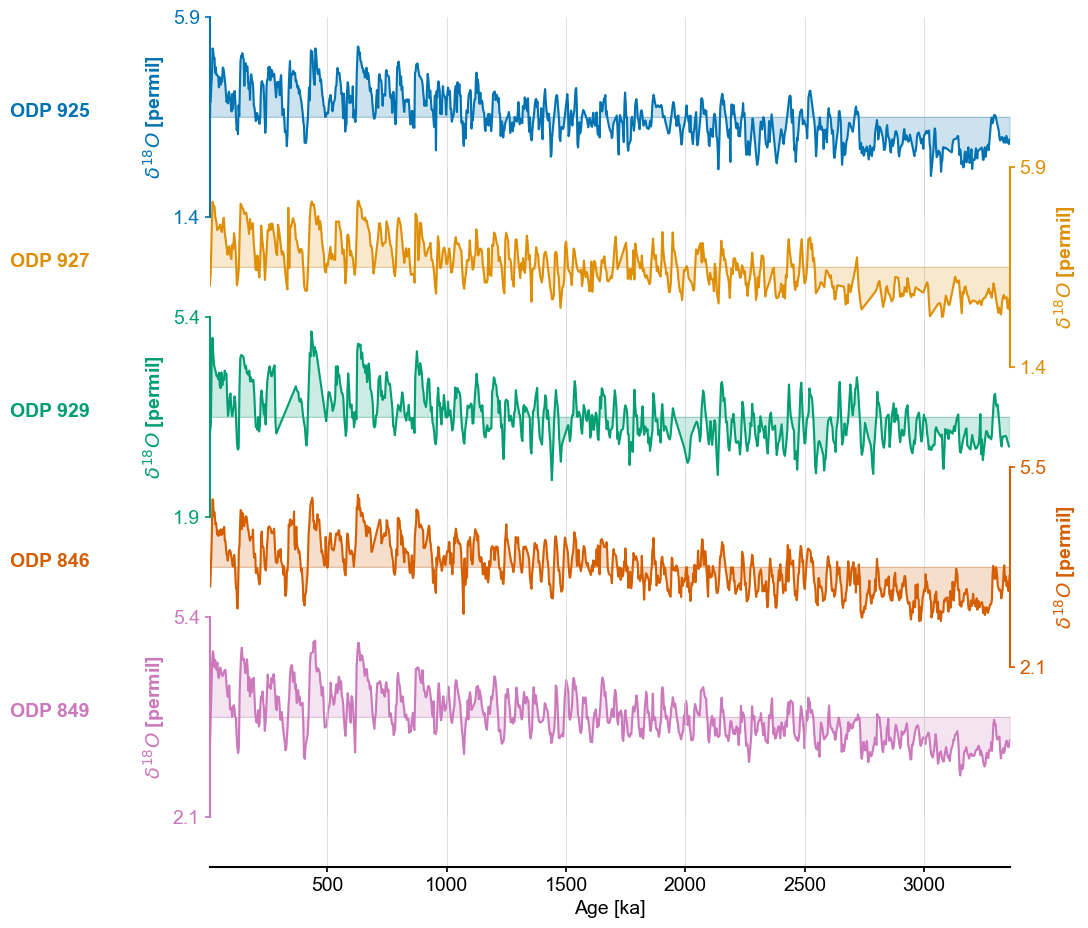

In [3]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('./data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,10))

In [4]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

Initial density is 0.0183
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0183
Epsilon: 1.1584, Density: 0.0499
Epsilon: 1.1584, Density: 0.0499.
Initial density is 0.0241
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0241
Epsilon: 1.1297, Density: 0.0511
Epsilon: 1.1297, Density: 0.0511.
Initial density is 0.0263
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0263
Epsilon: 1.1186, Density: 0.0547
Epsilon: 1.1186, Density: 0.0547.
Initial density is 0.1042
Initial density is not within the tolerance window, searching...
Epsilon: 0.4575, Density: 0.0016
Epsilon: 0.9417, Density: 0.0709
Epsilon: 0.9417, Density: 0.0709
Epsilon: 0.8373, Density: 0.0315
Epsilon: 0.8373, Density: 0.0315
Epsilon: 0.9300, Density: 0.0652
Epsilon: 0.9300, Density: 0.0652
Epsilon: 0.8537, Density: 0.0361
Epsilon: 0.8537, Density: 0.0361
Epsilon: 0.9234, Density: 0.0622
Epsilo

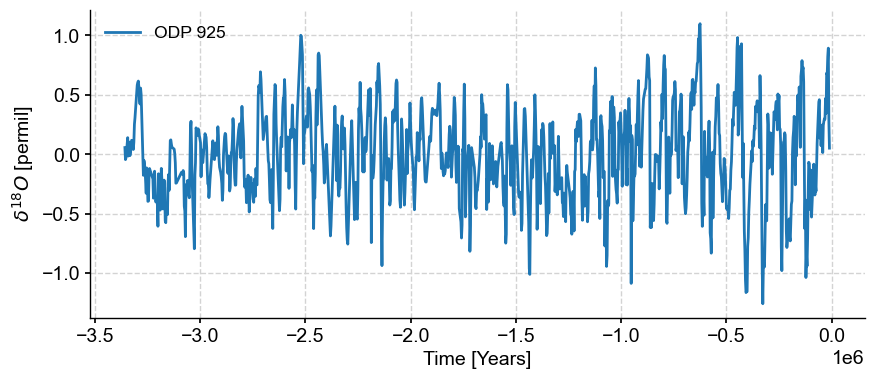

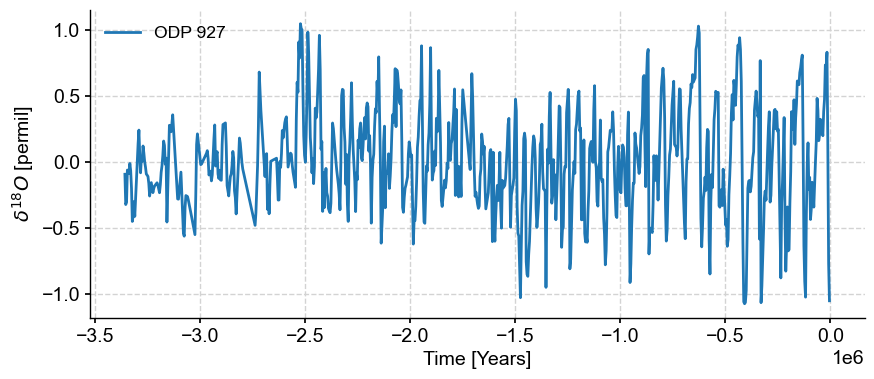

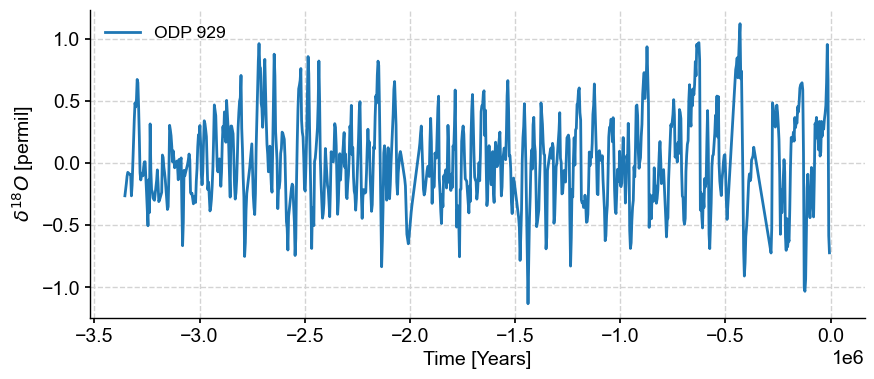

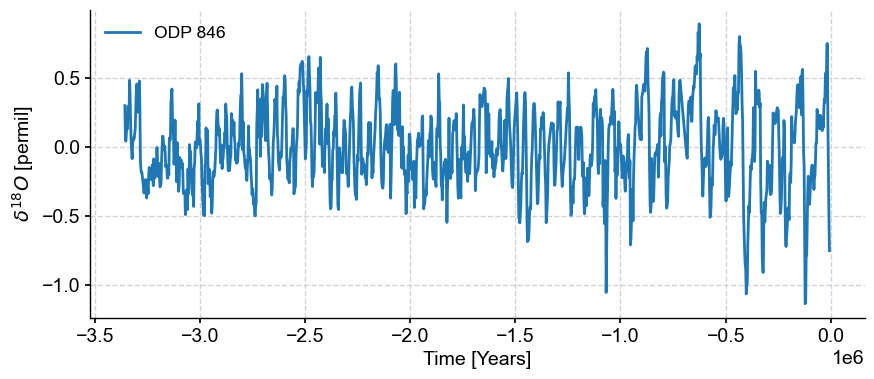

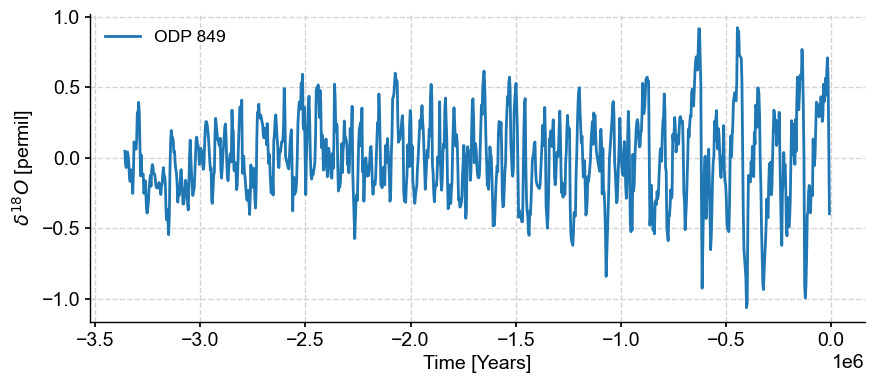

In [5]:
lp_rm = {}
lp_fi = {}

m = 13
tau = 8

for idx,series in enumerate(ms.series_list):
    series = series.convert_time_unit('Years').interp().detrend(method='savitzky-golay')
    series.plot()
    amt_series = amt.Series(
        time=series.time,
        value=series.value,
        time_name = series.time_name,
        value_name = series.value_name,
        time_unit = series.time_unit,
        value_unit = series.value_unit,
        label = series.label,
        clean_ts=False,
        sort_ts=None
    )
    td = amt_series.embed(m)
    eps = td.find_epsilon(1)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(50,5)
    lp_series = lp_series.convert_time_unit('ka')
    lp_fi[series.label] = lp_series

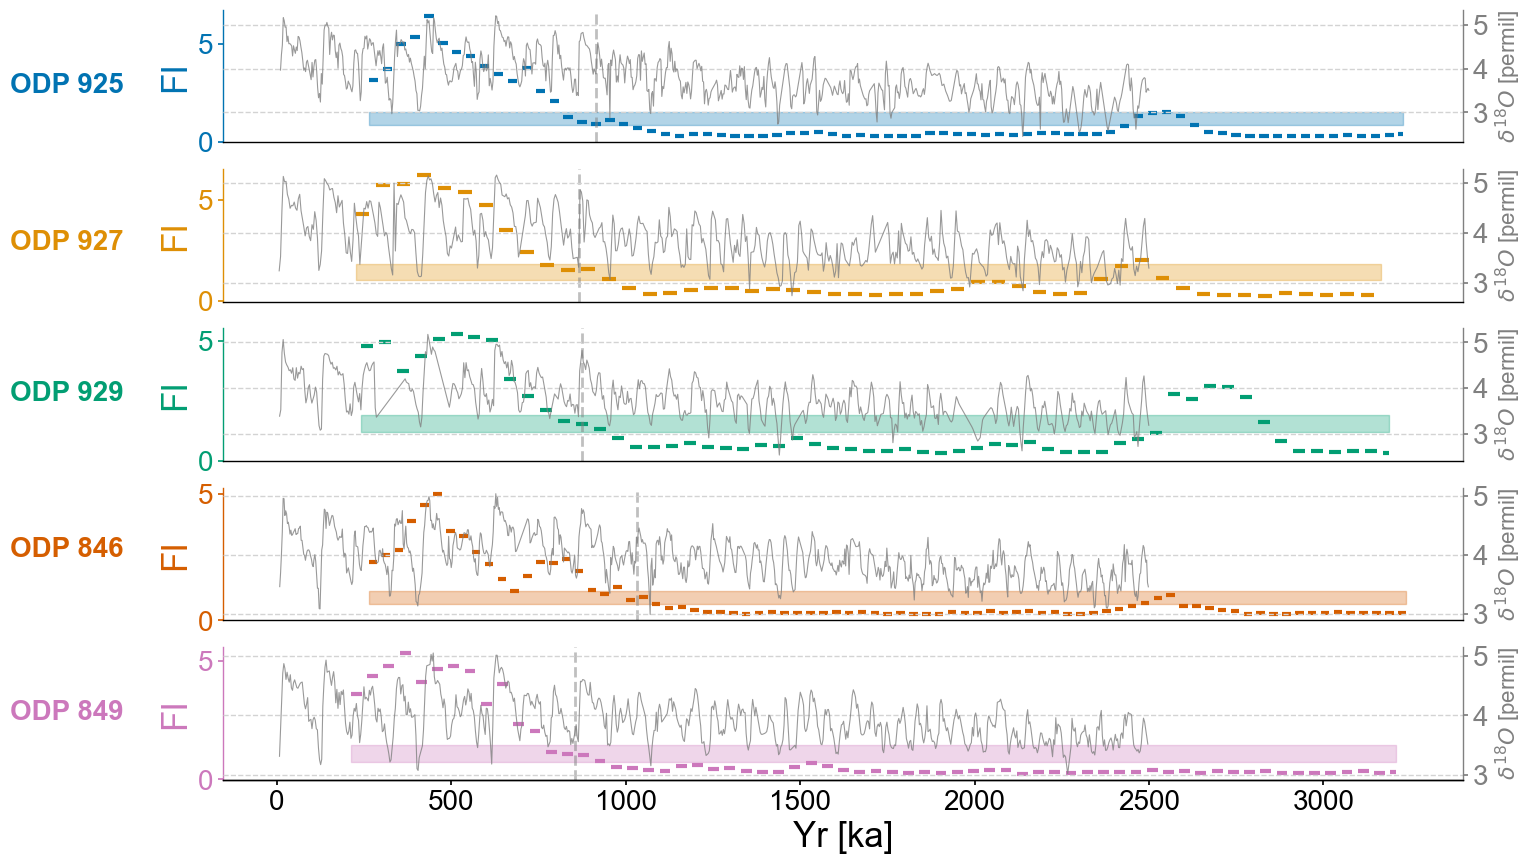

In [6]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(group_names),ncols=1,sharex=True,figsize=(16,10))
transition_timing = []

for idx,site in enumerate(group_names):
    ts = lp_fi[site]
    ts.label = lp_series.label
    ts.value_name = 'FI'
    ts.value_unit = None
    ts.time_name = 'Yr'
    ts.time_unit = 'ka'

    ax = axes[idx]
    ts_smooth = amt.utils.fisher.smooth_series(ts,3)
    upper, lower = amt.utils.sampling.confidence_interval(ts)
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))
    
    transition_timing.append(transitions[0])

    ts.confidence_smooth_plot(
        ax=ax,
        background_series = ms.series_list[idx].slice((0,2500)),
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})

    ax.axvline(transition_timing[idx],color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = site, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=20)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(group_names)-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))